In [2]:
# Import the necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score as acs_score

from src.data.data_fetcher import get_raw_data
from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data
pd.set_option('display.max_columns', 200)

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Prepare data
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()

X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)

x_whole.head()

X_test_estimated_a.shape = (2880, 47), X_test_estimated_b.shape = (2880, 47), X_test_estimated_c.shape = (2880, 47)
After temporal alignment
X_test_estimated_a.shape = (720, 47), X_test_estimated_b.shape = (720, 47), X_test_estimated_c.shape = (720, 47)
X_test_estimated_a_processed.shape = (720, 50), X_test_estimated_b_processed.shape = (720, 50), X_test_estimated_c_processed.shape = (720, 50)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,precip_5min:mm,precip_type_5min:idx,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,time_since_prediction,cloud_ratio,cloud_cover_over_30%,sun_addition,is_freezing,is_snow,is_rain,max_pv_location,average_pv_location,max_pv_location_times_sun_addition,average_pv_location_times_sun_addition
0,15.2,1.18175,1.351672e+06,440.600006,7231.174805,0.0,291.250000,95.500000,294605.53125,271.225006,872357.56250,54.224998,1.0,0.0,0.0,0.0,1007.500000,0.0,0.0,72.375000,92.172501,0.00,294.625000,98.925003,48152.375000,2.125,-2.000,-0.750,0.0,1,0,0,0.027950,-0.999609,1.000000,6.123234e-17,25901.988281,0.455669,0.645392,0,0.548142,1,366.725006,0,0,0,5733.42,814.880,2.102588e+06,298836.872974
1,13.7,1.19250,2.456032e+06,637.599976,1410.500000,0.0,289.399994,145.525009,447652.68750,5.800000,11749.87500,99.675003,1.0,0.0,0.0,0.0,1001.400024,0.0,0.1,80.699997,236.257751,0.10,292.100006,100.000000,5903.875000,1.350,-1.225,0.525,0.0,0,1,0,-0.310857,-0.950457,-0.500000,-8.660254e-01,844.045105,0.611489,0.004784,0,0.996750,1,151.325012,0,0,0,1152.30,129.375,1.743718e+05,19577.673454
2,10.5,1.20150,2.172293e+05,107.400002,2315.000000,0.0,285.299988,42.200001,100314.65625,65.099998,135992.90625,23.299999,1.0,0.0,0.0,0.0,1006.849976,0.0,0.0,59.049999,85.390503,0.00,291.700012,43.549999,49974.699219,3.375,-0.400,3.350,0.0,1,0,0,-0.804826,-0.593511,0.965926,2.588190e-01,2747.219971,0.164161,0.626034,0,0.535017,0,107.300003,0,0,0,5733.42,814.880,6.151960e+05,87436.626487
3,6.3,1.24800,0.000000e+00,0.000000,131.375000,0.0,277.100006,0.000000,0.00000,0.000000,0.00000,99.574997,0.0,1.0,0.0,0.0,992.949951,0.0,0.0,93.650002,127.701752,0.35,278.100006,99.974998,3399.375000,6.000,5.950,-0.500,0.0,1,0,0,-0.141444,0.989946,0.965926,-2.588190e-01,0.000000,0.000000,0.000000,0,0.995999,1,0.000000,0,0,0,5733.42,814.880,0.000000e+00,0.000000
4,6.3,1.27175,0.000000e+00,0.000000,8580.474609,0.0,277.000000,0.000000,0.00000,0.000000,0.00000,49.400002,0.0,1.0,0.0,0.0,1012.200012,0.0,0.0,81.649994,346.724243,0.00,278.600006,98.824997,27873.150391,1.450,1.450,-0.275,0.0,1,0,0,0.931210,-0.364483,-0.500000,8.660254e-01,0.000000,0.000000,0.000000,0,0.499874,1,0.000000,0,0,0,5733.42,814.880,0.000000e+00,0.000000


In [17]:
# Set up and run CatBoost
model = CatBoostRegressor(
    iterations=5000,
    depth=10,
    learning_rate=0.05,
    loss_function='MAE',  # Mean Absolute Error
    verbose=200  # Output training progress every 200 iterations
)

model.fit(x_whole, y_whole)

0:	learn: 303.7434788	total: 34.3ms	remaining: 5m 42s
200:	learn: 79.4948218	total: 4.96s	remaining: 4m 2s
400:	learn: 69.1181715	total: 9.62s	remaining: 3m 50s
600:	learn: 62.9216946	total: 14.3s	remaining: 3m 43s
800:	learn: 58.5277801	total: 18.9s	remaining: 3m 37s
1000:	learn: 55.9242543	total: 23.6s	remaining: 3m 31s
1200:	learn: 53.4502838	total: 28.2s	remaining: 3m 26s
1400:	learn: 50.9648782	total: 32.9s	remaining: 3m 21s
1600:	learn: 48.9488615	total: 37.6s	remaining: 3m 17s
1800:	learn: 46.7165627	total: 42.2s	remaining: 3m 12s
2000:	learn: 44.5638893	total: 46.9s	remaining: 3m 7s
2200:	learn: 42.6570930	total: 51.6s	remaining: 3m 3s
2400:	learn: 40.6840170	total: 56.4s	remaining: 2m 58s
2600:	learn: 39.2579496	total: 1m 1s	remaining: 2m 53s
2800:	learn: 38.0422364	total: 1m 5s	remaining: 2m 48s
3000:	learn: 36.6208744	total: 1m 10s	remaining: 2m 44s
3200:	learn: 35.2940338	total: 1m 15s	remaining: 2m 39s
3400:	learn: 33.7573145	total: 1m 20s	remaining: 2m 35s
3600:	learn: 32

In [18]:
train_prediction = model.predict(x_whole)

test_prediction = model.predict(X_val_est_combined)

# Evaluate the best model on the validation subset of the observed dataset
# leaderboard = automl.get_leaderboard()
# print(leaderboard)

mae_observed = mean_absolute_error(y_val_est_combined, test_prediction)

print(f'Mean Absolute Error on Validation Set: {mae_observed}')

Mean Absolute Error on Validation Set: 66.05051655353564


# Visualization

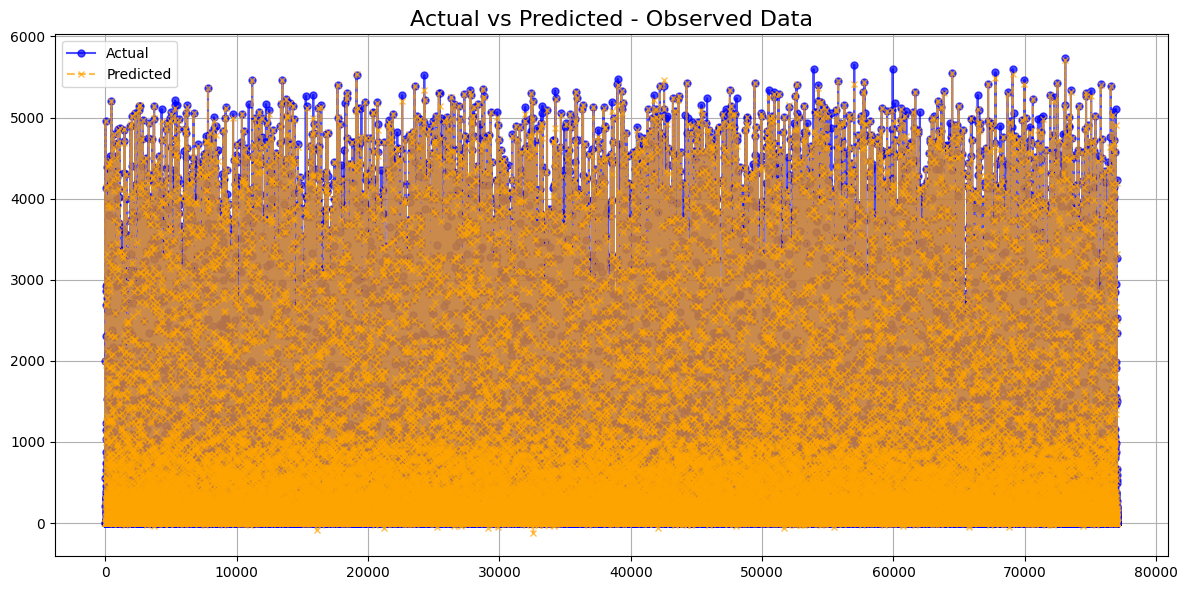

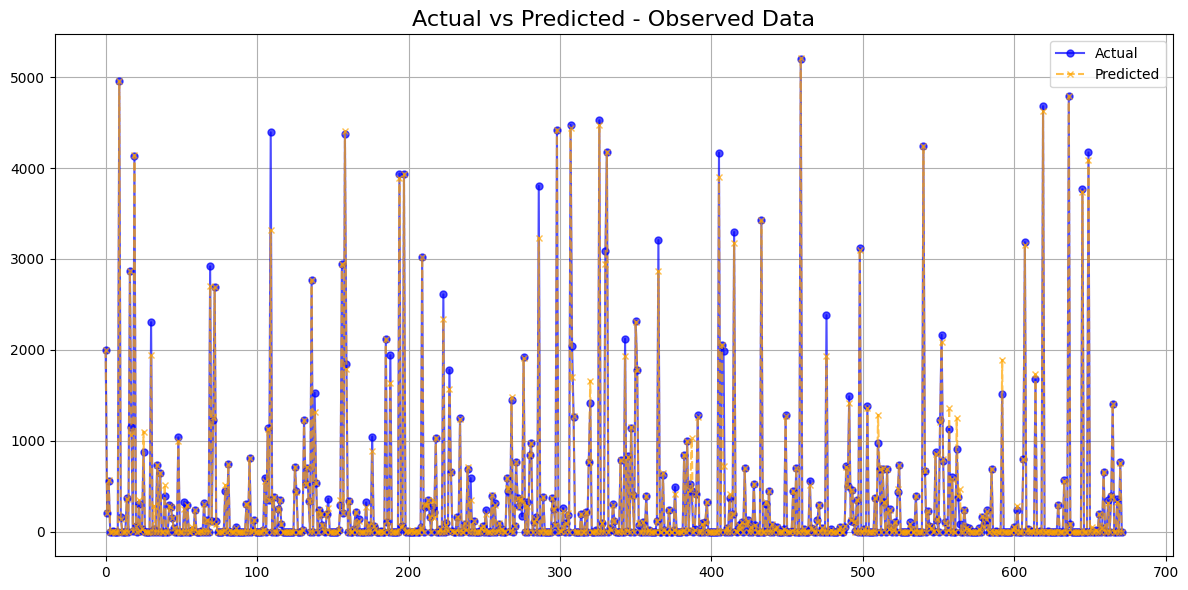

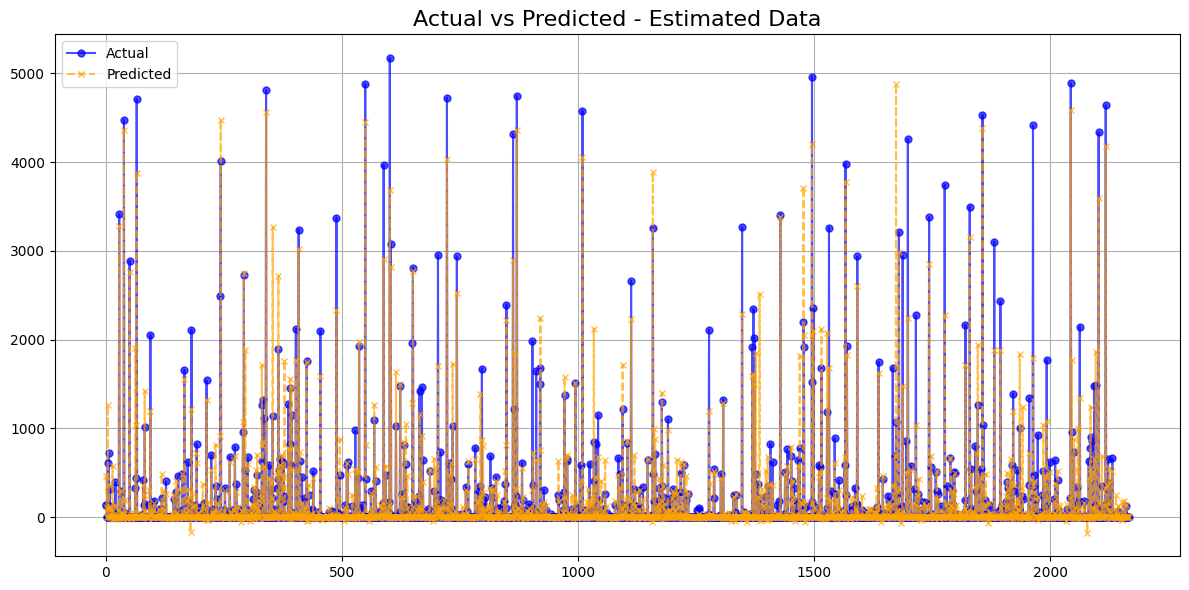

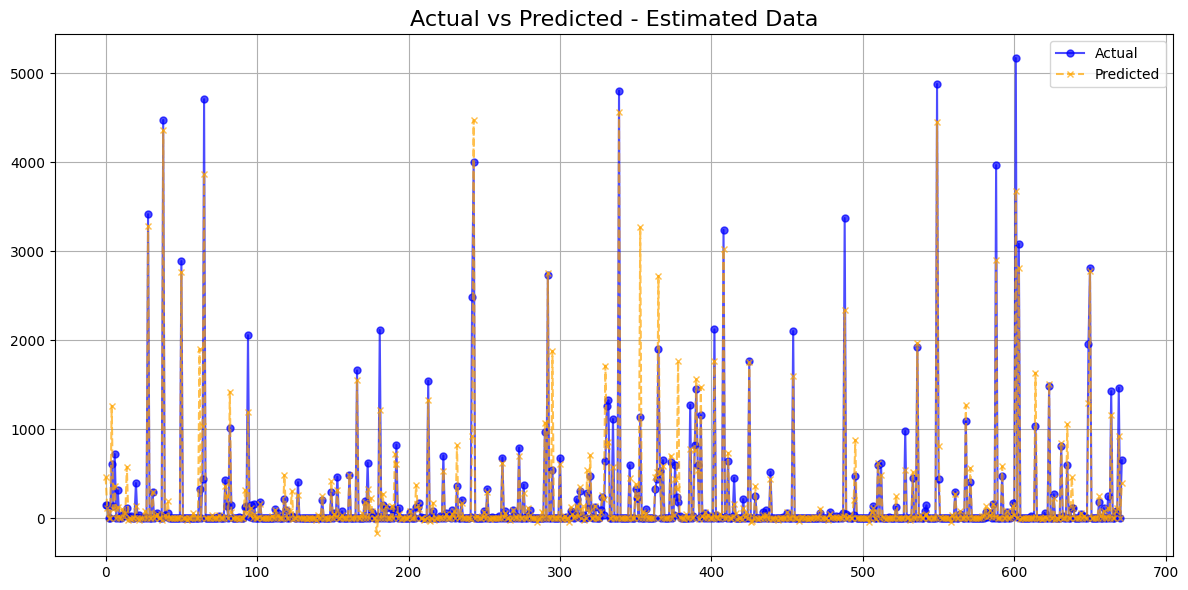

In [19]:
import matplotlib.pyplot as plt

# Observed Data
# Set up the plotting area
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_whole.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(train_prediction, label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualise the monthly predictions
# Observed Data
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_whole.reset_index(drop=True)[:24*7*4], label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(train_prediction[:24*7*4], label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Estimated Data
# Set up the plotting area
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_val_est_combined.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(test_prediction, label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Estimated Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualise the monthly predictions
# Estimated Data
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_val_est_combined.reset_index(drop=True)[:24*7*4], label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(test_prediction[:24*7*4], label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
plt.title('Actual vs Predicted - Estimated Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
y_pred = model.predict(x_test_whole)


In [16]:
# Save the model
from src.models.saving import save_predictions

save_predictions(y_pred, 'catboost')

   id  prediction
0   0    0.000000
1   1    0.000000
2   2    0.513542
3   3   51.518821
4   4  358.216171
